In [1]:
import numpy as np
import pandas as pd
import sys
sys.path.insert(0,"./src/")
from preprocess import *
from collections import deque
import matplotlib.pyplot as plt
import seaborn as sns
import copy

In [2]:
train = pd.read_csv("./data/dtree/train.csv",index_col=None)
x_train = train.iloc[:,:-1]
y_train = train.iloc[:,-1].as_matrix()

valid = pd.read_csv("./data/dtree/valid.csv",index_col=None)
x_valid = valid.iloc[:,:-1]
y_valid = valid.iloc[:,-1].as_matrix()

test = pd.read_csv("./data/dtree/test.csv",index_col=None)
x_test = test.iloc[:,:-1]
y_test = test.iloc[:,-1].as_matrix()

encodings = get_encodings(x_train,median_spit=True)
x_train = preprocess(x_train,encodings)
columns = x_train.columns
x_train = x_train.as_matrix()
x_valid = preprocess(x_valid,encodings).as_matrix()
x_test = preprocess(x_test,encodings).as_matrix()

In [3]:
class Node():
    def __init__(self,condition,col,pred):
        self.cond = condition
        self.col = col
        self.pred = pred
        self.parent = None
        self.children = []
        self.n_mis = []
        self.mis_pred = 0
        self.med = -1

    def get_split(self,x):
        return [np.where(c(x[:,self.col]))[0] for c in self.cond] if self.col != -1 else [np.arange(x.shape[0])]

    def is_leaf(self):
        return len(self.children) == 0

In [4]:
class DTree():
    def __init__(self):
        self.root = None
        self.node_count = 0

    def growTree(self,x_train,y_train,init_median_split=True,num_cols=[]):
        self.node_count += 1
        if(y_train.sum() == 0):
            self.root = Node(self.node_count,None,-1,0)
            return
        elif(y_train.sum() == y_train.shape[0]):
            self.root = Node(self.node_count,None,-1,1)
            return
        else:
            xjs, col, med_split = self.choose_best_attr(x_train,y_train,init_median_split,num_cols)
            c1 = np.count_nonzero(y_train)
            c0 = y_train.shape[0] - c1
            if(xjs is None):
                self.root = Node(None,-1,np.argmax([c0,c1]))
                return
            if(not med_split):
                conds = [(lambda x,c=c: x == c) for c in xjs]
            else:
                med = xjs[0]
                conds = [(lambda x: x >= med),(lambda x: x < med)]
            self.root = Node(conds,col,np.argmax([c0,c1]))
            nodes = deque([self.root])
            indices = deque([self.root.get_split(x_train)])
            while(len(nodes) != 0):
                curr = nodes.popleft()
                index = indices.popleft()
                for idx in index:
                    self.node_count += 1
                    if(y_train[idx].sum() == 0):
                        curr.children.append(Node(None,-1,0))
                        curr.children[-1].parent = curr
                        continue
                    elif(y_train[idx].sum() == y_train[idx].shape[0]):
                        curr.children.append(Node(None,-1,1))
                        curr.children[-1].parent = curr
                        continue
                    else:
                        xjs, col, med_split = self.choose_best_attr(x_train[idx],y_train[idx],init_median_split,num_cols)
                        c1 = np.count_nonzero(y_train[idx])
                        c0 = y_train[idx].shape[0] - c1
                        if(xjs is None):
                            curr.children.append(Node(None,-1,np.argmax([c0,c1])))
                            curr.children[-1].parent = curr
                            continue
                        if(not med_split):
                            conds = [(lambda x,c=c: x == c) for c in xjs]
                        else:
                            med = xjs[0]
                            conds = [(lambda x,med=med: x >= med),(lambda x,med=med: x < med)]
                        node = Node(conds,col,np.argmax([c0,c1]))
                        curr.children.append(node)
                        curr.children[-1].parent = curr
                        nodes.append(node)
                        split = node.get_split(x_train[idx])
                        indices.append([idx[s] for s in split])

    def choose_best_attr(self,x_train,y_train,init_median_split,num_cols):
        xjss, info_loss = [], []
        for col in range(x_train.shape[1]):
            flag = True if init_median_split else not col in num_cols
            if(flag):
                xjs = np.unique(x_train[:,col])
                xjss.append(xjs)
                if(xjs.shape[0] == 1):
                    info_loss.append(100)
                    continue
            else:
                med = np.median(x_train[:,col])
                mod_col = (x_train[:,col] >= med).astype(np.int64)
                xjss.append([med])
                mod_col_sum = mod_col.sum()
                if(mod_col_sum == 0 or mod_col_sum == x_train.shape[0]):
                    info_loss.append(100)
                    continue
                xjs = np.array([0,1])
            if(flag):
                P_xj = [(x_train[:,col] == xj).sum()/x_train.shape[0] for xj in xjs]
            else:
                P_xj = [(mod_col == xj).sum()/x_train.shape[0] for xj in xjs]
            ys = np.unique(y_train)
            H_y_xj = np.zeros(xjs.shape)
            for idx, xj in enumerate(xjs):
                P_y_xj = np.zeros(ys.shape)
                for idy, y in enumerate(ys):
                    if(flag):
                        P_y_xj[idy] = ((x_train[:,col] == xj)*(y_train == y)).sum()/(x_train[:,col] == xj).sum()
                    else:
                        P_y_xj[idy] = ((mod_col == xj)*(y_train == y)).sum()/(mod_col == xj).sum()
                H_y_xj[idx] = -1*(P_y_xj*np.log(P_y_xj + (P_y_xj == 0))).sum()
            info_loss.append((P_xj*H_y_xj).sum())
        best_col = np.argmin(info_loss)
        if(info_loss[best_col] == 100): return None, None, None
        med_split = False if init_median_split else (best_col in num_cols)
        return xjss[best_col], best_col, med_split
    
    def predict(self,x_test):
        def rec_predict(node,x_test,idx,pred):
            pred[idx] = node.pred
            if(not node.is_leaf()):
                split = node.get_split(x_test)
                for c, i in zip(node.children,split):
                    rec_predict(c,x_test[i],idx[i],pred)
        pred = np.ones(x_test.shape[0],dtype=np.int64) * -1
        rec_predict(self.root,x_test,np.arange(x_test.shape[0]),pred)
        return pred
    
    def dfs_acc(self,x_test,y_test,label_mis=False):
        def rec_dfs(node,x_test,y_test,idx,pred,acc):
            pred[idx] = node.pred
            acc.append((pred == y_test).sum()/y_test.shape[0])
            if(label_mis):
                curr.n_mis = [(y_test[idx] == 0).sum(),(y_test[idx] == 1).sum(),(pred[idx] != y_test[idx]).sum()]
            if(not node.is_leaf()):
                split = node.get_split(x_test)
                if(label_mis):
                    oi = np.ones(len(idx),dtype=bool)
                    for i in split:
                        oi[i] = False
                    curr.n_mis[-1] = (pred[idx[oi]] != y_test[idx[oi]]).sum()
                for c, i in zip(node.children,split):
                    rec_dfs(c,x_test[i],y_test,idx[i],pred,acc)
        pred = np.ones(x_test.shape[0],dtype=np.int64) * -1
        acc = []
        rec_dfs(self.root,x_test,y_test,np.arange(x_test.shape[0]),pred,acc)
        return np.array(acc)
    
    def bfs_acc(self,x_test,y_test,label_mis=False):
        pred = np.ones(x_test.shape[0],dtype=np.int64) * -1
        acc = []
        nodes = deque([self.root])
        indices = deque([np.arange(x_test.shape[0])])
        data = deque([x_test])
        while(len(nodes) != 0):
            curr = nodes.popleft()
            idx = indices.popleft()
            x = data.popleft()
            pred[idx] = curr.pred
            acc.append((pred == y_test).sum()/y_test.shape[0])
            if(label_mis):
                curr.n_mis = [(y_test[idx] == 0).sum(),(y_test[idx] == 1).sum(),(pred[idx] != y_test[idx]).sum()]
            if(not curr.is_leaf()):
                split = curr.get_split(x)
                nodes.extend(curr.children)
                indices.extend([idx[i] for i in split])
                data.extend([x[i] for i in split])
                if(label_mis):
                    oi = np.ones(len(idx),dtype=bool)
                    for i in split:
                        oi[i] = False
                    curr.n_mis[-1] = (pred[idx[oi]] != y_test[idx[oi]]).sum()
        return np.array(acc)
    
    def get_nodes(self,reset_mispred=False):
        nodes = []
        node_count = [0]
        def rec_get_nodes(node,depth,node_count):
            node_count[0] += 1
            if(reset_mispred): node.mis_pred = node.n_mis[-1]
            if(len(nodes) < depth + 1):
                nodes.append([node])
            else:
                nodes[depth].append(node)
            for n in node.children:
                rec_get_nodes(n,depth+1,node_count)
        rec_get_nodes(self.root,0,node_count)
        self.node_count = node_count[0]
        return nodes
        
    def post_prune(self,x_valid,y_valid,x_data,y_data,verbose=False):
        if(len(self.root.n_mis) == 0): self.bfs_acc(x_valid,y_valid,label_mis=True)
        def rec_prune():
            nodes = self.get_nodes(reset_mispred=True)
            for sub_n in nodes[::-1]:
                for n in sub_n:
                    if(not n.parent is None):
                        n.parent.mis_pred += n.mis_pred
            best_node, prune_cost = None, 0
            for sub_n in nodes:
                for n in sub_n:
                    prune_mis = n.n_mis[0] if n.pred == 1 else n.n_mis[1]
                    no_prune_mis = n.mis_pred
                    curr_prune_cost = prune_mis - no_prune_mis
                    if(curr_prune_cost < prune_cost and not n.is_leaf()):
                        best_node, prune_cost = n, curr_prune_cost
            if(not best_node is None):
                best_node.children = []
                best_node.n_mis[-1] = prune_mis
                return 0
            else:
                return -1
        node_counts, train_acc, valid_acc, test_acc = [], [], [], []
        p1, p2 = x_train.shape[0], x_train.shape[0]+x_valid.shape[0]
        while(rec_prune() == 0):
            node_counts.append(self.node_count)
            p = self.predict(x_data)
            train_acc.append((p[:p1] == y_data[:p1]).sum()/p1)
            valid_acc.append((p[p1:p2] == y_data[p1:p2]).sum()/(p2-p1))
            test_acc.append((p[p2:] == y_data[p2:]).sum()/(y_data.shape[0]-p2))
            if(verbose):
                print("Node Count = {0}".format(self.node_count),end=" | ")
                print("Validation Accuracy = {0}".format((self.predict(x_valid) == y_valid).sum()/y_valid.shape[0]))
        return np.array(node_counts) ,np.array(train_acc), np.array(valid_acc), np.array(test_acc)

In [5]:
%%time

tree = DTree()
tree.growTree(x_train,y_train,init_median_split=True)

CPU times: user 2.66 s, sys: 11.6 ms, total: 2.67 s
Wall time: 2.67 s


In [6]:
%%time

print("Number of Nodes = {0}".format(tree.node_count))
p_train = tree.predict(x_train)
print("Train Accuracy = {0:.5f}".format((p_train == y_train).sum()/y_train.shape[0]))
p_valid = tree.predict(x_valid)
print("Validation Accuracy = {0:.5f}".format((p_valid == y_valid).sum()/y_valid.shape[0]))
p_test = tree.predict(x_test)
print("Test Accuracy = {0:.5f}".format((p_test == y_test).sum()/y_test.shape[0]))

Number of Nodes = 7972
Train Accuracy = 0.88933
Validation Accuracy = 0.79933
Test Accuracy = 0.80671
CPU times: user 231 ms, sys: 7.75 ms, total: 239 ms
Wall time: 236 ms


In [7]:
%%time

train_acc = tree.bfs_acc(x_train,y_train)
valid_acc = tree.bfs_acc(x_valid,y_valid)
test_acc = tree.bfs_acc(x_test,y_test)

CPU times: user 1.01 s, sys: 23.9 ms, total: 1.03 s
Wall time: 1.03 s


<IPython.core.display.Javascript object>


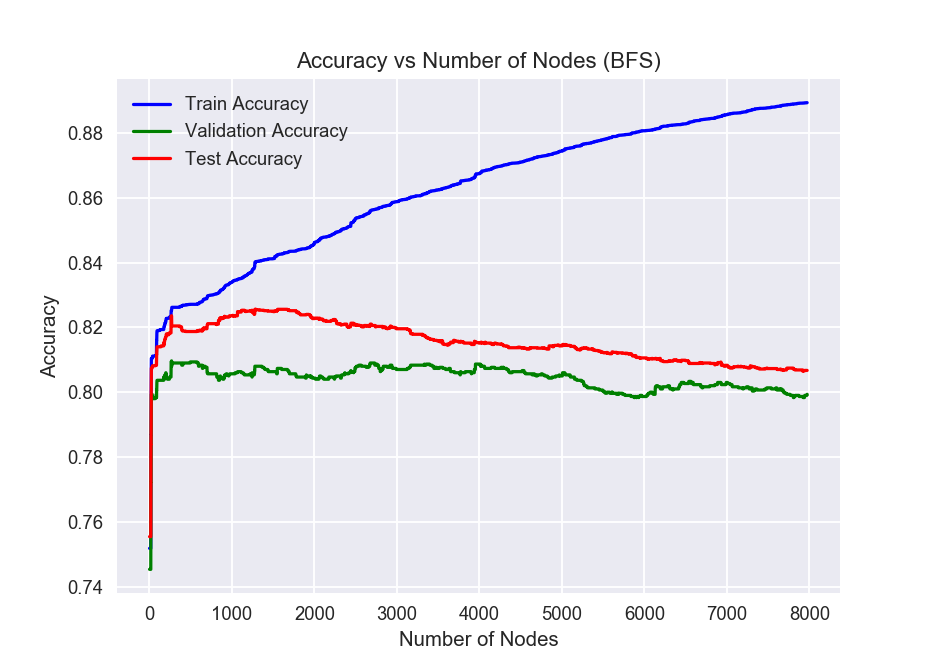

In [8]:
%matplotlib notebook

sns.set()
fig = plt.figure(figsize=(7,5))
train_patch = plt.plot(np.arange(1,tree.node_count+1),train_acc,color='b',label='Train Accuracy')[0]
valid_patch = plt.plot(np.arange(1,tree.node_count+1),valid_acc,color='g',label='Validation Accuracy')[0]
test_patch = plt.plot(np.arange(1,tree.node_count+1),test_acc,color='r',label='Test Accuracy')[0]
plt.xlabel("Number of Nodes")
plt.ylabel("Accuracy")
plt.legend(handles=[train_patch,valid_patch,test_patch])
plt.title("Accuracy vs Number of Nodes (BFS)")
plt.show()

In [9]:
%%time

train_acc = tree.dfs_acc(x_train,y_train)
valid_acc = tree.dfs_acc(x_valid,y_valid)
test_acc = tree.dfs_acc(x_test,y_test)

CPU times: user 1.12 s, sys: 0 ns, total: 1.12 s
Wall time: 1.12 s


<IPython.core.display.Javascript object>


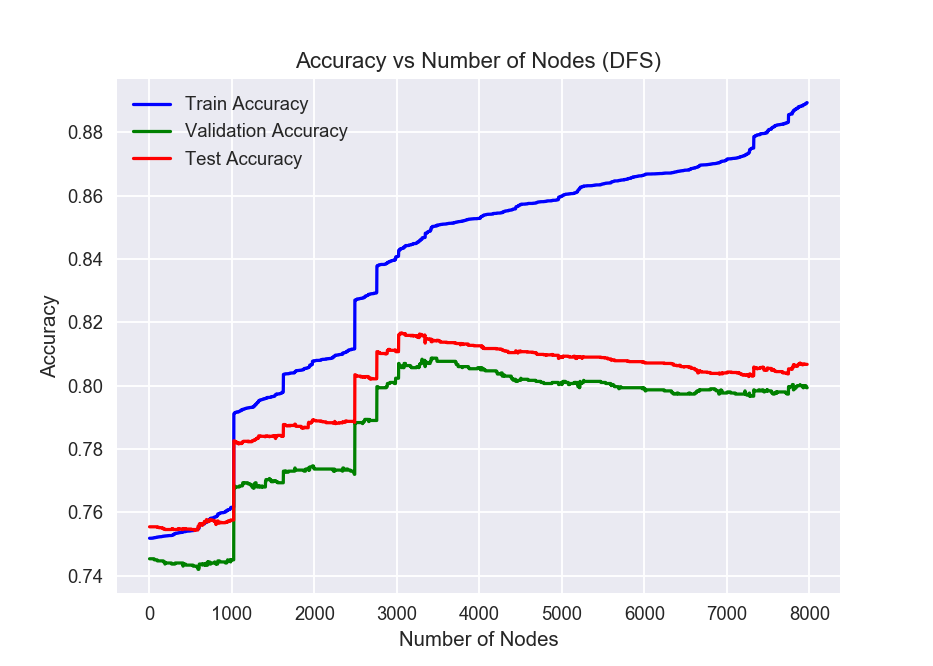

In [10]:
%matplotlib notebook

sns.set()
fig = plt.figure(figsize=(7,5))
train_patch = plt.plot(np.arange(1,tree.node_count+1),train_acc,color='b',label='Train Accuracy')[0]
valid_patch = plt.plot(np.arange(1,tree.node_count+1),valid_acc,color='g',label='Validation Accuracy')[0]
test_patch = plt.plot(np.arange(1,tree.node_count+1),test_acc,color='r',label='Test Accuracy')[0]
plt.xlabel("Number of Nodes")
plt.ylabel("Accuracy")
plt.legend(handles=[train_patch,valid_patch,test_patch])
plt.title("Accuracy vs Number of Nodes (DFS)")
plt.show()

In [11]:
%%time

x_data = np.concatenate((x_train,x_valid,x_test),axis=0)
y_data = np.concatenate((y_train,y_valid,y_test),axis=0)
node_counts, train_acc, valid_acc, test_acc = tree.post_prune(x_valid,y_valid,x_data,y_data,verbose=False)

CPU times: user 2.74 s, sys: 15 ms, total: 2.75 s
Wall time: 2.75 s


In [12]:
%%time

print("Number of Nodes = {0}".format(tree.node_count))
p_train = tree.predict(x_train)
print("Train Accuracy = {0:.5f}".format((p_train == y_train).sum()/y_train.shape[0]))
p_valid = tree.predict(x_valid)
print("Validation Accuracy = {0:.5f}".format((p_valid == y_valid).sum()/y_valid.shape[0]))
p_test = tree.predict(x_test)
print("Test Accuracy = {0:.5f}".format((p_test == y_test).sum()/y_test.shape[0]))

Number of Nodes = 2322
Train Accuracy = 0.84893
Validation Accuracy = 0.83467
Test Accuracy = 0.82557
CPU times: user 77.2 ms, sys: 70 µs, total: 77.2 ms
Wall time: 76.3 ms


<IPython.core.display.Javascript object>


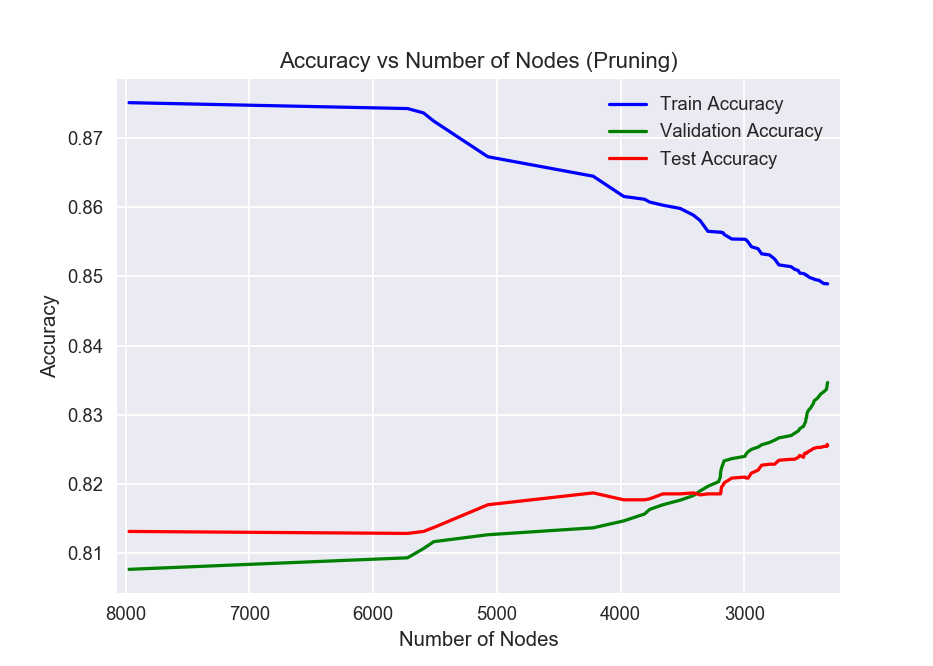

In [13]:
%matplotlib notebook

sns.set()
fig = plt.figure(figsize=(7,5))
train_patch = plt.plot(node_counts,train_acc,color='b',label='Train Accuracy')[0]
valid_patch = plt.plot(node_counts,valid_acc,color='g',label='Validation Accuracy')[0]
test_patch = plt.plot(node_counts,test_acc,color='r',label='Test Accuracy')[0]
plt.xlim(node_counts.max()+100,node_counts.min()-100)
plt.xlabel("Number of Nodes")
plt.ylabel("Accuracy")
plt.legend(handles=[train_patch,valid_patch,test_patch])
plt.title("Accuracy vs Number of Nodes (Pruning)")
plt.show()

In [14]:
x_train = train.iloc[:,:-1]
x_valid = valid.iloc[:,:-1]
x_test = test.iloc[:,:-1]

encodings = get_encodings(x_train,median_spit=False)
x_train = preprocess(x_train,encodings)
columns = x_train.columns
num_cols = [np.argmax(columns == c) for c in list(set(columns) - set(encodings))]
x_train = x_train.as_matrix()
x_valid = preprocess(x_valid,encodings).as_matrix()
x_test = preprocess(x_test,encodings).as_matrix()

In [15]:
%%time

tree = DTree()
tree.growTree(x_train,y_train,init_median_split=False,num_cols=num_cols)

CPU times: user 7.19 s, sys: 39.4 ms, total: 7.23 s
Wall time: 7.24 s


In [16]:
%%time

print("Number of Nodes = {0}".format(tree.node_count))
p_train = tree.predict(x_train)
print("Train Accuracy = {0:.5f}".format((p_train == y_train).sum()/y_train.shape[0]))
p_valid = tree.predict(x_valid)
print("Validation Accuracy = {0:.5f}".format((p_valid == y_valid).sum()/y_valid.shape[0]))
p_test = tree.predict(x_test)
print("Test Accuracy = {0:.5f}".format((p_test == y_test).sum()/y_test.shape[0]))

Number of Nodes = 16495
Train Accuracy = 0.99989
Validation Accuracy = 0.78800
Test Accuracy = 0.77914
CPU times: user 520 ms, sys: 7.99 ms, total: 528 ms
Wall time: 518 ms


In [17]:
%%time

train_acc = tree.bfs_acc(x_train,y_train)
valid_acc = tree.bfs_acc(x_valid,y_valid)
test_acc = tree.bfs_acc(x_test,y_test)

CPU times: user 2.13 s, sys: 7.57 ms, total: 2.13 s
Wall time: 2.14 s


<IPython.core.display.Javascript object>


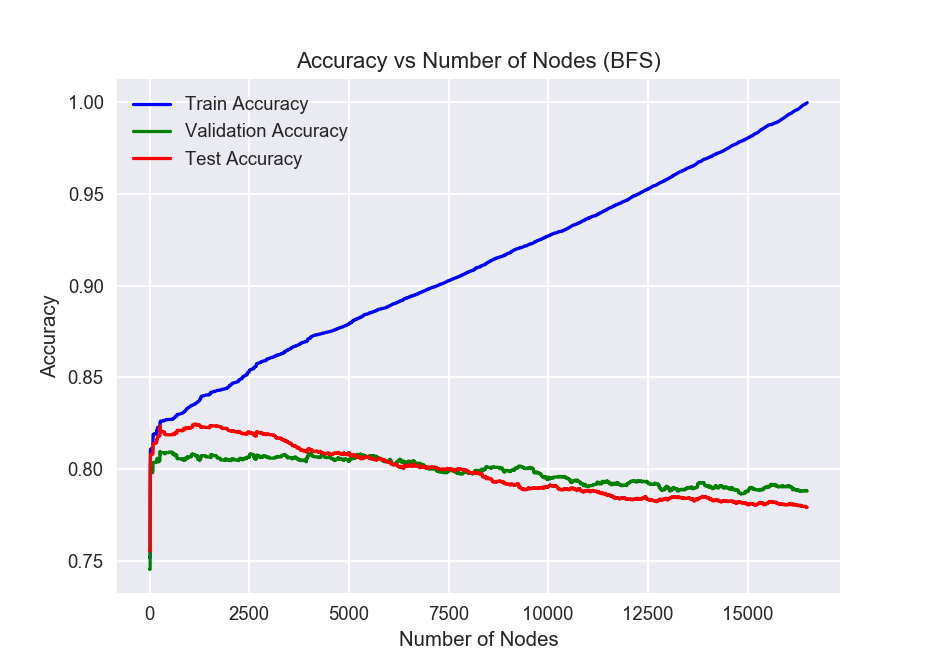

In [18]:
%matplotlib notebook

sns.set()
fig = plt.figure(figsize=(7,5))
train_patch = plt.plot(np.arange(1,tree.node_count+1),train_acc,color='b',label='Train Accuracy')[0]
valid_patch = plt.plot(np.arange(1,tree.node_count+1),valid_acc,color='g',label='Validation Accuracy')[0]
test_patch = plt.plot(np.arange(1,tree.node_count+1),test_acc,color='r',label='Test Accuracy')[0]
plt.xlabel("Number of Nodes")
plt.ylabel("Accuracy")
plt.legend(handles=[train_patch,valid_patch,test_patch])
plt.title("Accuracy vs Number of Nodes (BFS)")
plt.show()

In [19]:
%%time

train_acc = tree.dfs_acc(x_train,y_train)
valid_acc = tree.dfs_acc(x_valid,y_valid)
test_acc = tree.dfs_acc(x_test,y_test)

CPU times: user 2.26 s, sys: 3.66 ms, total: 2.26 s
Wall time: 2.27 s


<IPython.core.display.Javascript object>


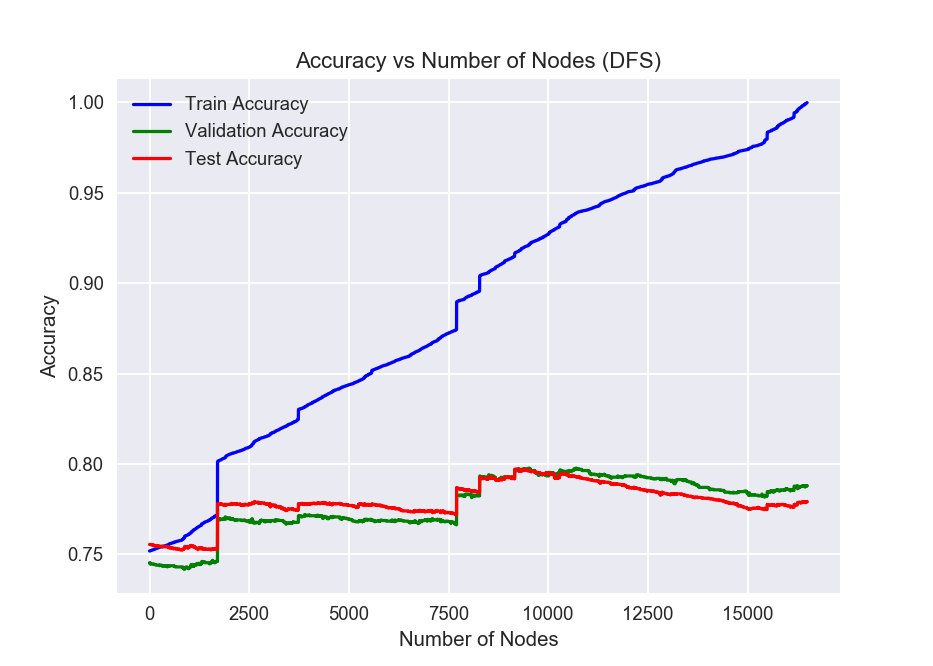

CPU times: user 38.3 ms, sys: 4.12 ms, total: 42.5 ms
Wall time: 41.7 ms


In [20]:
%%time

sns.set()
fig = plt.figure(figsize=(7,5))
train_patch = plt.plot(np.arange(1,tree.node_count+1),train_acc,color='b',label='Train Accuracy')[0]
valid_patch = plt.plot(np.arange(1,tree.node_count+1),valid_acc,color='g',label='Validation Accuracy')[0]
test_patch = plt.plot(np.arange(1,tree.node_count+1),test_acc,color='r',label='Test Accuracy')[0]
plt.xlabel("Number of Nodes")
plt.ylabel("Accuracy")
plt.legend(handles=[train_patch,valid_patch,test_patch])
plt.title("Accuracy vs Number of Nodes (DFS)")
plt.show()

In [21]:
%%time

nodes = tree.get_nodes()
counts = dict(zip(num_cols,[0]*len(num_cols)))
for sub_n in nodes:
    for n in sub_n:
        try:
            counts[n.col] += 1
        except KeyError:
            continue
for c in counts:
    print("{0} - {1}".format(columns[c],counts[c]))

Age - 3446
 Fnlwgt - 2194
 Education Number - 0
 Capital Gain - 18
 Capital Loss - 6
 Hour per Week - 536
CPU times: user 20.3 ms, sys: 3.8 ms, total: 24.1 ms
Wall time: 23.7 ms


In [22]:
%%time

x_data = np.concatenate((x_train,x_valid,x_test),axis=0)
y_data = np.concatenate((y_train,y_valid,y_test),axis=0)
node_counts, train_acc, valid_acc, test_acc = tree.post_prune(x_valid,y_valid,x_data,y_data,verbose=False)

CPU times: user 5.85 s, sys: 15.4 ms, total: 5.86 s
Wall time: 5.86 s


In [23]:
%%time

print("Number of Nodes = {0}".format(tree.node_count))
p_train = tree.predict(x_train)
print("Train Accuracy = {0:.5f}".format((p_train == y_train).sum()/y_train.shape[0]))
p_valid = tree.predict(x_valid)
print("Validation Accuracy = {0:.5f}".format((p_valid == y_valid).sum()/y_valid.shape[0]))
p_test = tree.predict(x_test)
print("Test Accuracy = {0:.5f}".format((p_test == y_test).sum()/y_test.shape[0]))

Number of Nodes = 3650
Train Accuracy = 0.87230
Validation Accuracy = 0.84167
Test Accuracy = 0.81429
CPU times: user 122 ms, sys: 3.56 ms, total: 126 ms
Wall time: 125 ms


<IPython.core.display.Javascript object>


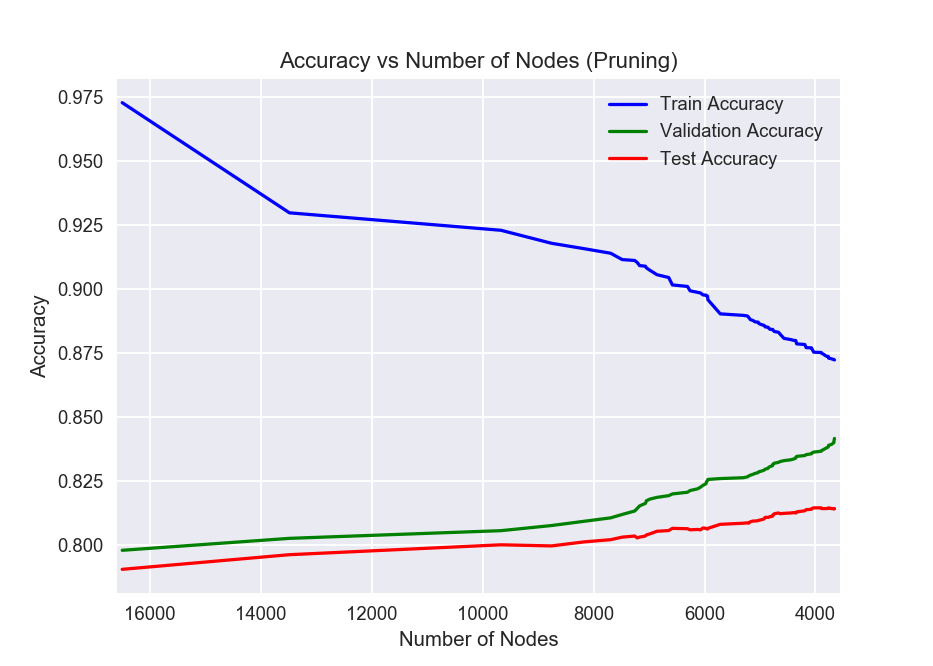

In [24]:
%matplotlib notebook

sns.set()
fig = plt.figure(figsize=(7,5))
train_patch = plt.plot(node_counts,train_acc,color='b',label='Train Accuracy')[0]
valid_patch = plt.plot(node_counts,valid_acc,color='g',label='Validation Accuracy')[0]
test_patch = plt.plot(node_counts,test_acc,color='r',label='Test Accuracy')[0]
plt.xlim(node_counts.max()+100,node_counts.min()-100)
plt.xlabel("Number of Nodes")
plt.ylabel("Accuracy")
plt.legend(handles=[train_patch,valid_patch,test_patch])
plt.title("Accuracy vs Number of Nodes (Pruning)")
plt.show()